# House Pricing Model Comparison and Optimization

## Imports and Setup

In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns                      
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
            
%matplotlib inline     
sns.set(color_codes=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

## Load Dataset

In [142]:
df = pd.read_csv("../data/cleaned/housePricing_model.csv")

## Train-Test Split

I will split the data like this: 80% for training and 20% for testing.

In [143]:
x = df.drop(["SalePrice"], axis=1)
y = df["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("Y_train shape:", y_train.shape)
print("Y_test shape:", y_test.shape)

original_columns = x_train.columns

X_train shape: (1160, 289)
X_test shape: (291, 289)
Y_train shape: (1160,)
Y_test shape: (291,)


## Output Directories Setup

In [144]:
output_dir_csv = "../data/results"
output_dir_plot = "../plots/model_comp"
output_dir_models = "../models"
os.makedirs(output_dir_csv, exist_ok=True)
os.makedirs(output_dir_plot, exist_ok=True)
os.makedirs(output_dir_models, exist_ok=True)

# PHASE 1: Baseline Model Comparison

Here i will setup models with some basic parameters.

In [145]:
kfold = KFold(n_splits=5, shuffle=True, random_state=100)
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
baseline_models = {
    'Ridge': RidgeCV(alphas=ridge_alphas, cv=kfold),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=100),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=100),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=100, verbose=-1),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=10, min_samples_leaf=4, random_state=100),
    'SVR': SVR(C=1.0, epsilon=0.1),
    'DecisionTree': DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10, random_state=100),
    'KNN': KNeighborsRegressor(n_neighbors=5)
}

phase1_results = []

training the models using scaler through a pipeline to reduce data leakage.

In [146]:
for name, model in baseline_models.items():
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)
    ])
    pipeline.fit(x_train, y_train)
    y_pred_train = pipeline.predict(x_train)
    y_pred_test = pipeline.predict(x_test)
    
    phase1_results.append({
        'Model': name,
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2 Train': r2_score(y_train, y_pred_train),
        'R2 Test': r2_score(y_test, y_pred_test),
        'MSE Train': mean_squared_error(y_train, y_pred_train),
        'MSE Test': mean_squared_error(y_test, y_pred_test),
        'MAE Train': mean_absolute_error(y_train, y_pred_train),
        'MAE Test': mean_absolute_error(y_test, y_pred_test)
    })

c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Phase 1 Results

Creating a table to visualize model performance.

In [147]:
phase1_df = pd.DataFrame(phase1_results).sort_values('RMSE Test', ascending=True)
phase1_df.to_csv(os.path.join(output_dir_csv, "phase1_basic_comparison.csv"), index=False)
display(phase1_df.style.background_gradient(cmap="viridis"))

,Model,RMSE Train,RMSE Test,R2 Train,R2 Test,MSE Train,MSE Test,MAE Train,MAE Test
0,Ridge,0.096127,0.121331,0.940250,0.909154,0.009240,0.014721,0.068252,0.079471
3,LightGBM,0.062754,0.134983,0.974535,0.887560,0.003938,0.018220,0.044138,0.088999
1,GradientBoosting,0.037565,0.142531,0.990875,0.874634,0.001411,0.020315,0.029330,0.094962
2,XGBoost,0.042669,0.144123,0.988227,0.871817,0.001821,0.020771,0.031962,0.095778
5,SVR,0.076116,0.153181,0.962537,0.855198,0.005794,0.023464,0.064193,0.097637
4,RandomForest,0.084109,0.153398,0.954256,0.854787,0.007074,0.023531,0.055675,0.102065
7,KNN,0.139700,0.185438,0.873804,0.787792,0.019516,0.034387,0.099201,0.126009
6,DecisionTree,0.122925,0.203834,0.902292,0.743599,0.015111,0.041548,0.091177,0.144995


# PHASE 2: Hyperparameter Tuning

Making parameter configurations for models i want to tune. Skipping Ridge because it has cross-validation already. Also skipping DecisionTree and KNN because they performed the worst.

In [148]:
tune_configs = [
    {
        'name': 'GradientBoosting',
        'model': GradientBoostingRegressor(random_state=100),
        'params': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__learning_rate': [0.05, 0.1, 0.2],
            'regressor__max_depth': [3, 5, 7],
            'regressor__min_samples_leaf': [2, 4, 6],
            'regressor__subsample': [0.8, 0.9, 1.0]
        },
        'n_iter': 20
    },
    {
        'name': 'XGBoost',
        'model': XGBRegressor(random_state=100),
        'params': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [3, 5, 7],
            'regressor__min_child_weight': [1, 3, 5],
            'regressor__subsample': [0.8, 0.9, 1.0],
            'regressor__colsample_bytree': [0.8, 0.9, 1.0]
        },
        'n_iter': 20
    },
    {
        'name': 'LightGBM',
        'model': LGBMRegressor(random_state=100, verbose=-1),
        'params': {
            'regressor__n_estimators': [100, 200, 300, 500, 1000],
            'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'regressor__max_depth': [2, 5, 8, 10],
            'regressor__num_leaves': [31, 50, 100],
            'regressor__min_child_samples': [5, 10, 20],
            'regressor__lambda_l1' : [0.0001, 0.001, 0.01],
            'regressor__lambda_l2' : [0, 0.0001, 0.001, 0.01]
        },
        'n_iter': 20
    },
    {
        'name': 'RandomForest',
        'model': RandomForestRegressor(random_state=100),
        'params': {
            'regressor__n_estimators': [100, 200, 300],
            'regressor__max_depth': [10, 15, 20, None],
            'regressor__min_samples_split': [2, 5, 10],
            'regressor__min_samples_leaf': [1, 2, 4]
        },
        'n_iter': 20
    },
    {
        'name': 'SVR',
        'model': SVR(),
        'params': {
            'regressor__C': [0.1, 1, 10, 100],
            'regressor__gamma': ['scale', 'auto'],
            'regressor__epsilon': [0.01, 0.1, 0.5],
            'regressor__kernel': ['rbf']
        },
        'n_iter': 12
    }
]

phase2_results = []
best_models = {}

Tuning the models using RandomizedSearchCV for a faster output

In [149]:
best_models['Ridge'] = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RidgeCV(alphas=ridge_alphas, cv=kfold))
]).fit(x_train, y_train)

for config in tune_configs:
    print(f"Tuning {config['name']}...")
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', config['model'])
    ])
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=config['params'],
        n_iter=config['n_iter'],
        cv=kfold,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=100,
        verbose=0
    )
    search.fit(x_train, y_train)
    best_model = search.best_estimator_
    best_models[config['name']] = best_model
    
    y_pred_train = best_model.predict(x_train)
    y_pred_test = best_model.predict(x_test)
    
    phase2_results.append({
        'Model': config['name'],
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2 Train': r2_score(y_train, y_pred_train),
        'R2 Test': r2_score(y_test, y_pred_test),
        'MSE Train': mean_squared_error(y_train, y_pred_train),
        'MSE Test': mean_squared_error(y_test, y_pred_test),
        'MAE Train': mean_absolute_error(y_train, y_pred_train),
        'MAE Test': mean_absolute_error(y_test, y_pred_test)
    })

Tuning GradientBoosting...
Tuning XGBoost...
Tuning LightGBM...


c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Tuning RandomForest...
Tuning SVR...


## Phase 2 Results

Visualizing the tuned model scores

In [150]:
phase2_df = pd.DataFrame(phase2_results).sort_values('RMSE Test', ascending=True)
phase2_df.to_csv(os.path.join(output_dir_csv, "phase2_tuned_comparison.csv"), index=False)
display(phase2_df.style.background_gradient(cmap="viridis"))

,Model,RMSE Train,RMSE Test,R2 Train,R2 Test,MSE Train,MSE Test,MAE Train,MAE Test
4,SVR,0.047576,0.124398,0.985364,0.904502,0.002263,0.015475,0.020228,0.078711
1,XGBoost,0.065115,0.131786,0.972583,0.892822,0.004240,0.017368,0.046825,0.088835
0,GradientBoosting,0.080106,0.134656,0.958506,0.888104,0.006417,0.018132,0.057848,0.090521
2,LightGBM,0.098225,0.135576,0.937612,0.886570,0.009648,0.018381,0.070188,0.091098
3,RandomForest,0.050713,0.152330,0.983370,0.856802,0.002572,0.023205,0.035049,0.101929


# PHASE 3: Weighted Blended Model

Creating a class in case i need to save this as the best model

In [151]:
class BlendedRegressor:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights
        
    def predict(self, X):
        final_pred = 0
        for name, weight in self.weights.items():
            final_pred += weight * self.models[name].predict(X)
        return final_pred

    def fit(self, X, y):
        pass

Making a model using blending which is a technique that gives different weightage to different algorithms that will affect their influence on the predictions. I chose these weights randomly, however the model can be improved by tuning the weights.

In [152]:
def blended_predictions(X):
    return (
        0.20 * best_models['Ridge'].predict(X) +
        0.20 * best_models['SVR'].predict(X) +
        0.15 * best_models['GradientBoosting'].predict(X) +
        0.20 * best_models['XGBoost'].predict(X) +
        0.20 * best_models['LightGBM'].predict(X) +
        0.05 * best_models['RandomForest'].predict(X)
    )

Training the blended model and showing it's R2 score

In [153]:
y_pred_train_blend = blended_predictions(x_train)
y_pred_test_blend = blended_predictions(x_test)

blended_result = {
    'Model': 'Weighted Blend',
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_blend)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_blend)),
    'R2 Train': r2_score(y_train, y_pred_train_blend),
    'R2 Test': r2_score(y_test, y_pred_test_blend),
    'MSE Train': mean_squared_error(y_train, y_pred_train_blend),
    'MSE Test': mean_squared_error(y_test, y_pred_test_blend),
    'MAE Train': mean_absolute_error(y_train, y_pred_train_blend),
    'MAE Test': mean_absolute_error(y_test, y_pred_test_blend)
}
print(f"Weighted Blend R2 Test: {blended_result['R2 Test']:.4f}")

Weighted Blend R2 Test: 0.9063


c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\cozid\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Final Results with All Models

Adding ridge model to the final results and visualizing them within a table

In [154]:
y_pred_train_ridge = best_models['Ridge'].predict(x_train)
y_pred_test_ridge = best_models['Ridge'].predict(x_test)

phase2_results.append({
    'Model': 'Ridge',
    'RMSE Train': np.sqrt(mean_squared_error(y_train, y_pred_train_ridge)),
    'RMSE Test': np.sqrt(mean_squared_error(y_test, y_pred_test_ridge)),
    'R2 Train': r2_score(y_train, y_pred_train_ridge),
    'R2 Test': r2_score(y_test, y_pred_test_ridge),
    'MSE Train': mean_squared_error(y_train, y_pred_train_ridge),
    'MSE Test': mean_squared_error(y_test, y_pred_test_ridge),
    'MAE Train': mean_absolute_error(y_train, y_pred_train_ridge),
    'MAE Test': mean_absolute_error(y_test, y_pred_test_ridge)
})

final_results = phase2_results + [blended_result]
final_df = pd.DataFrame(final_results).sort_values('RMSE Test', ascending=True)
final_df.to_csv(os.path.join(output_dir_csv, "final_comparison_with_blend.csv"), index=False)
display(final_df.style.background_gradient(cmap="viridis"))

,Model,RMSE Train,RMSE Test,R2 Train,R2 Test,MSE Train,MSE Test,MAE Train,MAE Test
5,Ridge,0.096127,0.121331,0.940250,0.909154,0.009240,0.014721,0.068252,0.079471
6,Weighted Blend,0.069250,0.123219,0.968991,0.906305,0.004796,0.015183,0.047166,0.079734
4,SVR,0.047576,0.124398,0.985364,0.904502,0.002263,0.015475,0.020228,0.078711
1,XGBoost,0.065115,0.131786,0.972583,0.892822,0.004240,0.017368,0.046825,0.088835
0,GradientBoosting,0.080106,0.134656,0.958506,0.888104,0.006417,0.018132,0.057848,0.090521
2,LightGBM,0.098225,0.135576,0.937612,0.886570,0.009648,0.018381,0.070188,0.091098
3,RandomForest,0.050713,0.152330,0.983370,0.856802,0.002572,0.023205,0.035049,0.101929


# Best Model Visualization and Export

Saving the weights for the blended model because i would need them if this was the best model.

In [155]:
weights = {
    'Ridge': 0.20,
    'SVR': 0.20,
    'GradientBoosting': 0.15,
    'XGBoost': 0.20,
    'LightGBM': 0.20,
    'RandomForest': 0.05
}

weights_df = pd.DataFrame([weights])
weights_path = os.path.join(output_dir_models, "blend_weights.csv")
weights_df.to_csv(weights_path, index=False)

best_model_name = final_df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")

if best_model_name == 'Weighted Blend':
    final_model = BlendedRegressor(models=best_models, weights=weights)
    y_pred_final = y_pred_test_blend
else:
    final_model = best_models[best_model_name]
    y_pred_final = final_model.predict(x_test)

best_model_path = os.path.join(output_dir_models, "best_model.pkl")
joblib.dump(final_model, best_model_path)
print(f"Best model saved to: {best_model_path}")
print("Saved weights")

Best Model: Ridge
Best model saved to: ../models\best_model.pkl
Saved weights


Using a scatter plot to see the difference between actual and predicted prices

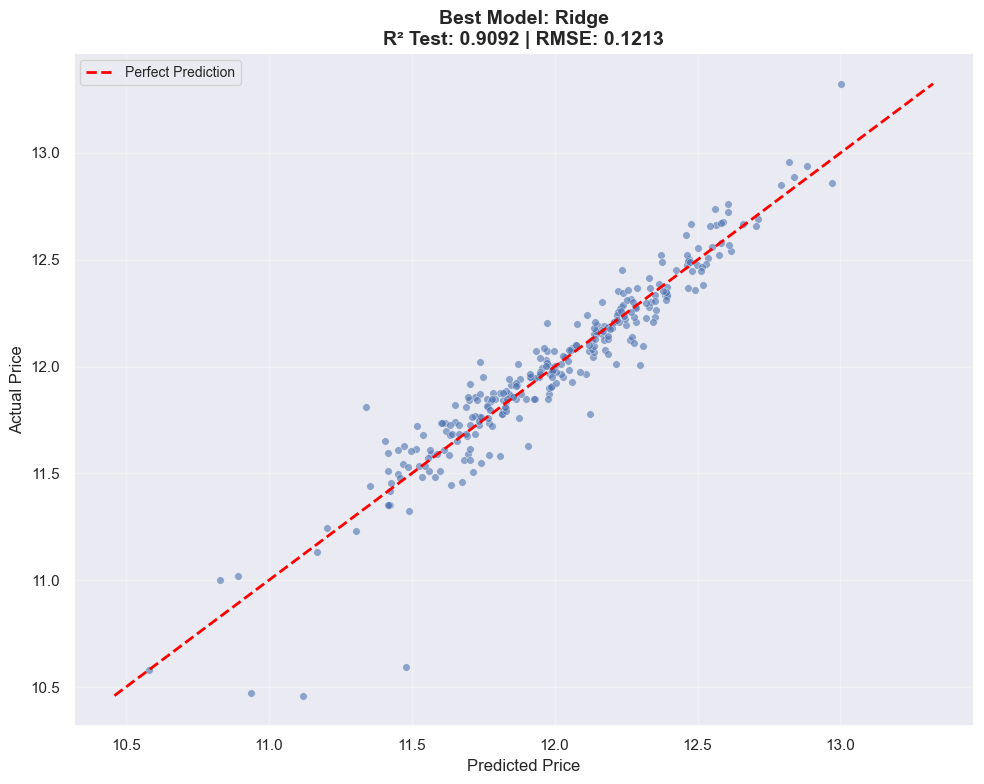

In [156]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred_final, y=y_test, alpha=0.6, s=30)
plt.title(f'Best Model: {best_model_name}\nR² Test: {final_df.iloc[0]["R2 Test"]:.4f} | RMSE: {final_df.iloc[0]["RMSE Test"]:.4f}', 
          fontsize=14, weight='bold')
plt.xlabel('Predicted Price', fontsize=12)
plt.ylabel('Actual Price', fontsize=12)

min_val = min(min(y_pred_final), min(y_test))
max_val = max(max(y_pred_final), max(y_test))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

best_model_plot = os.path.join(output_dir_plot, f"BEST_MODEL_{best_model_name.replace(' ', '_')}.png")
plt.savefig(best_model_plot, facecolor='white', dpi=300)
plt.show()
plt.close()

## Save All Models

In [157]:
for name, model in best_models.items():
    joblib.dump(model, os.path.join(output_dir_models, f"{name}_model.pkl"))

scaler = RobustScaler()
scaler.fit(x_train)
scaler_path = os.path.join(output_dir_models, "scaler.pkl")
joblib.dump(scaler, scaler_path)

weights_df = pd.DataFrame([weights])
weights_path = os.path.join(output_dir_models, "blend_weights.csv")
weights_df.to_csv(weights_path, index=False)
    
print(f"All models saved")

All models saved


I also need to save the model columns to use in my interface

In [158]:
columns_path = os.path.join(output_dir_models, "model_columns.pkl")
joblib.dump(x_train.columns, columns_path)

print(f"Column list saved to: {columns_path}")

Column list saved to: ../models\model_columns.pkl
